<img src="https://pytorch.org/assets/images/classification.jpg" alt="alt" width="50%"/>

# 모델 설명
* GPUNets는 NVIDIA GPU 및 TensorRT의 성능을 최대화하도록 자동 설계된 NVIDIA의 배포 및 생산 준비가 된 Convolutional Neural Networks의 새로운 제품군입니다.

* 새로운 Neural Architecture Search(NAS) 방법을 사용하여 NVIDIA AI로 제작된 GPUNet은 EfficientNet-X 및 FBNet-V3보다 최대 2배 빠른 최첨단 추론 성능을 보여줍니다. 이 노트북을 사용하면 CVPR-2022 문서에 나열된 모든 GPUNet 모델 구현을 로드하고 테스트할 수 있습니다. 이 노트북을 사용하여 나열된 각 모델을 빠르게 로드하여 추론 실행을 수행할 수 있습니다.

In [1]:
!pip install validators matplotlib -q
!pip install timm==0.5.4 -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.5/431.5 KB 8.8 MB/s eta 0:00:00


In [2]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

# 내 cpu에 있는 gpu성능을 보여줌
if torch.cuda.is_available():
    device = torch.device("cuda") 
    !nvidia-smi
else:
    device = torch.device("cpu")

print(f'Using {device} for inference')

Mon Feb 13 07:52:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    31W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


| TorchHub model | Description |
| :----- | :----- |
| `GPUNet-0` | GPUNet-0 has the fastest measured latency on GV100 |
| `GPUNet-1` | GPUNet-1 has improved accuracy with one additional layer on GPUNet-0|
| `GPUNet-2` | GPUNet-2 has higher accuracy with two additional layers on GPUNet-0 |
| `GPUNet-P0` | GPUNet-P0 is the distilled model with higher accuracy than GPUNet-0 but similar latency|
| `GPUNet-P1` | GPUNet-P1 is distilled model with even higher accuracy than GPUNet-1 but similar latency |
| `GPUNet-D1` | GPUNet-D1 has the second highest accuracy amongst all GPUNets|
| `GPUNet-D2` | GPUNet-D2 has the highest accuracy amongst all GPUNets |

# 실험 시작
## gpunet-0 : 속도 빠름. 생명체를 위주로 잘 맞춘다. 풍경은 잘 맞추지 못함

In [3]:
model_type = "GPUNet-0" # 위에서 하나 선택 (자유)
precision = "fp64" # fps 32, fps  64중에서 하나를 선택 (GPU의 32 or 64비트를 말하는 것 같습니다)

# 로드
gpunet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_gpunet', pretrained=True, model_type=model_type, model_math=precision)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')
print("GPU NET 다운로드를 진행중입니다.... \n 10초 가량의 시간이 걸릴 수 있습니다.")

# GPUnet을 gpu에 저장
gpunet.to(device)

# 신경망 모델 확인
gpunet.eval()

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip


model_type= GPUNet-0
mapped model latency= 0.65ms
testing:  batch= 1  latency= 0.65ms  gpu= GV100


0B [00:00, ?B/s]

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


GPU NET 다운로드를 진행중입니다.... 
 10초 가량의 시간이 걸릴 수 있습니다.


GPUNet(
  (network): Sequential(
    (head: 2): prologue_i3_o32_s2_swish
    (stage: 1 layer3): conv_k3_i32_o32_s1_relu
    (stage: 1 layer4): conv_k3_i32_o32_s1_relu
    (stage: 2 layer5): er_k3_e5_i32_o32_s2_relu_se_False
    (stage: 2 layer6): er_k3_e5_i32_o32_s1_relu_se_False
    (stage: 3 layer7): er_k3_e5_i32_o64_s2_relu_se_False
    (stage: 3 layer8): er_k3_e5_i64_o64_s1_relu_se_False
    (stage: 3 layer9): er_k3_e5_i64_o64_s1_relu_se_False
    (stage: 4 layer10): irb_k3_e5_i64_o256_s2_swish_se_False
    (stage: 4 layer11): irb_k3_e5_i256_o256_s1_swish_se_False
    (stage: 4 layer12): irb_k3_e5_i256_o256_s1_swish_se_False
    (stage: 6 layer13): irb_k3_e5_i256_o704_s2_relu_se_True
    (stage: 6 layer14): irb_k3_e5_i704_o704_s1_relu_se_True
    ( layer15): epilogue_i704_o1280_s1_relu
  )
)

# 이미지 순서 
* 비생물체, 생물체, 인간, 풍경, 우주, 추상 객체, 상상의 동물(개체)

In [4]:
uris = ['https://cdn.pixabay.com/photo/2017/06/07/10/53/pizza-2380025_1280.jpg',
        'https://cdn.pixabay.com/photo/2019/07/23/13/51/shepherd-dog-4357790_1280.jpg',
        'https://cdn.pixabay.com/photo/2020/01/23/16/42/embrace-4788167_1280.jpg',
        'https://cdn.pixabay.com/photo/2015/12/01/20/28/road-1072823_1280.jpg',
        'https://images.pexels.com/photos/1676530/pexels-photo-1676530.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2',
        'https://media.wired.com/photos/615204854a9e495923621ef1/master/pass/Games-Diablo_LordOfTerror_2D_Desktop.jpg'
        ]

# batch크기 : uris에서 지원
batch = torch.cat(
    [utils.prepare_input_from_uri(uri) for uri in uris]
).to(device)

if precision == "fp16":
    batch = batch.half()
    
print("추론을 진행중입니다....")

추론을 진행중입니다....


In [5]:
# 텍스트 추론
with torch.no_grad():
    output = torch.nn.functional.softmax(gpunet(batch), dim=1)
    
results = utils.pick_n_best(predictions=output, n=5)

sample 0: [('pizza, pizza pie', '94.5%'), ('pomegranate', '0.2%'), ('pretzel', '0.2%'), ('trifle', '0.2%'), ('wooden spoon', '0.1%')]
sample 1: [('German shepherd, German shepherd dog, German police dog, alsatian', '71.4%'), ('malinois', '8.6%'), ('Australian terrier', '1.0%'), ('Leonberg', '0.7%'), ('kelpie', '0.5%')]
sample 2: [('whistle', '15.8%'), ('bulletproof vest', '5.2%'), ('flute, transverse flute', '2.7%'), ('accordion, piano accordion, squeeze box', '2.6%'), ('wig', '2.4%')]
sample 3: [('valley, vale', '50.6%'), ('lakeside, lakeshore', '4.5%'), ('maze, labyrinth', '2.6%'), ('groom, bridegroom', '1.5%'), ('park bench', '1.3%')]
sample 4: [('padlock', '6.4%'), ('chainlink fence', '6.0%'), ('mailbox, letter box', '4.1%'), ('switch, electric switch, electrical switch', '4.0%'), ('gas pump, gasoline pump, petrol pump, island dispenser', '2.5%')]
sample 5: [('crayfish, crawfish, crawdad, crawdaddy', '29.9%'), ('American lobster, Northern lobster, Maine lobster, Homarus americanus'

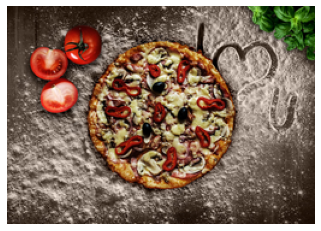

[('pizza, pizza pie', '94.5%'), ('pomegranate', '0.2%'), ('pretzel', '0.2%'), ('trifle', '0.2%'), ('wooden spoon', '0.1%')]


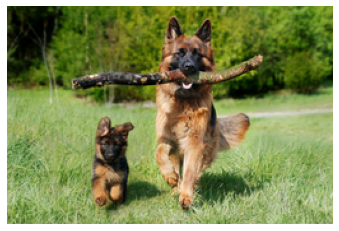

[('German shepherd, German shepherd dog, German police dog, alsatian', '71.4%'), ('malinois', '8.6%'), ('Australian terrier', '1.0%'), ('Leonberg', '0.7%'), ('kelpie', '0.5%')]


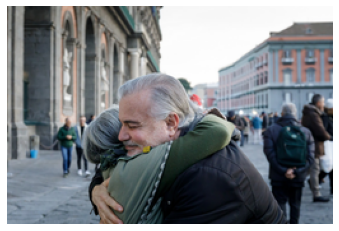

[('whistle', '15.8%'), ('bulletproof vest', '5.2%'), ('flute, transverse flute', '2.7%'), ('accordion, piano accordion, squeeze box', '2.6%'), ('wig', '2.4%')]


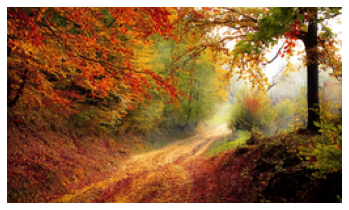

[('valley, vale', '50.6%'), ('lakeside, lakeshore', '4.5%'), ('maze, labyrinth', '2.6%'), ('groom, bridegroom', '1.5%'), ('park bench', '1.3%')]


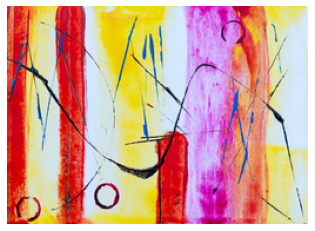

[('padlock', '6.4%'), ('chainlink fence', '6.0%'), ('mailbox, letter box', '4.1%'), ('switch, electric switch, electrical switch', '4.0%'), ('gas pump, gasoline pump, petrol pump, island dispenser', '2.5%')]


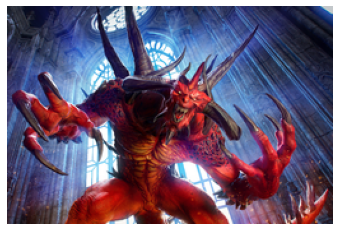

[('crayfish, crawfish, crawdad, crawdaddy', '29.9%'), ('American lobster, Northern lobster, Maine lobster, Homarus americanus', '20.0%'), ('triceratops', '18.0%'), ('spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish', '10.1%'), ('walking stick, walkingstick, stick insect', '0.9%')]


In [6]:
for uri, result in zip(uris, results):
    img = Image.open(requests.get(uri, stream=True).raw)
    img.thumbnail((256,256), Image.ANTIALIAS)
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    
    print(result)

# 추론할 데이터 준비
* 추론을 위해 입력물 샘플을 준비했습니다

# 강아지 품종

## 강아지 이미지 로드

1
https://cdn.pixabay.com/photo/2018/03/31/06/31/dog-3277416_1280.jpg

2
https://cdn.pixabay.com/photo/2019/08/19/07/45/corgi-4415649_1280.jpg

3
https://cdn.pixabay.com/photo/2018/05/07/10/48/husky-3380548_1280.jpg

4
https://cdn.pixabay.com/photo/2013/07/07/04/58/weimaraner-143753_1280.jpg

5
https://cdn.pixabay.com/photo/2017/07/31/21/15/dog-2561134_1280.jpg

## 주로 흔하지 않은 품종

6
https://cdn.pixabay.com/photo/2014/04/05/11/40/dog-316598_1280.jpg

7
https://cdn.pixabay.com/photo/2016/11/23/18/06/dog-1854119_1280.jpg

8
https://cdn.pixabay.com/photo/2017/12/29/10/23/nature-3047194_1280.jpg

9
https://cdn.pixabay.com/photo/2020/11/24/17/54/dog-5773397_1280.jpg

10
https://cdn.pixabay.com/photo/2020/03/22/15/25/fetch-4957501_1280.jpg

In [ ]:
uris = ['https://cdn.pixabay.com/photo/2018/03/31/06/31/dog-3277416_1280.jpg',
        'https://cdn.pixabay.com/photo/2019/08/19/07/45/corgi-4415649_1280.jpg',
        'https://cdn.pixabay.com/photo/2018/05/07/10/48/husky-3380548_1280.jpg',
        'https://cdn.pixabay.com/photo/2013/07/07/04/58/weimaraner-143753_1280.jpg',
        'https://cdn.pixabay.com/photo/2017/07/31/21/15/dog-2561134_1280.jpg',
        'https://cdn.pixabay.com/photo/2014/04/05/11/40/dog-316598_1280.jpg',
        'https://cdn.pixabay.com/photo/2016/11/23/18/06/dog-1854119_1280.jpg',
        'https://cdn.pixabay.com/photo/2017/12/29/10/23/nature-3047194_1280.jpg',
        'https://cdn.pixabay.com/photo/2020/11/24/17/54/dog-5773397_1280.jpg',
        'https://cdn.pixabay.com/photo/2020/03/22/15/25/fetch-4957501_1280.jpg']

model_type= GPUNet-0
mapped model latency= 0.65ms
testing:  batch= 1  latency= 0.65ms  gpu= GV100


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


0B [00:00, ?B/s]

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


추론을 진행중입니다....
sample 0: [('vizsla, Hungarian pointer', '75.8%'), ('Rhodesian ridgeback', '5.0%'), ('Weimaraner', '1.8%'), ('English foxhound', '0.3%'), ('redbone', '0.3%')]
sample 1: [('Cardigan, Cardigan Welsh corgi', '26.6%'), ('Pembroke, Pembroke Welsh corgi', '24.9%'), ('brambling, Fringilla montifringilla', '1.9%'), ('basenji', '1.2%'), ('goldfish, Carassius auratus', '0.9%')]
sample 2: [('Eskimo dog, husky', '74.7%'), ('Siberian husky', '14.6%'), ('timber wolf, grey wolf, gray wolf, Canis lupus', '1.9%'), ('dogsled, dog sled, dog sleigh', '0.7%'), ('white wolf, Arctic wolf, Canis lupus tundrarum', '0.3%')]
sample 3: [('Great Dane', '17.8%'), ('Doberman, Doberman pinscher', '8.9%'), ('black-and-tan coonhound', '5.9%'), ('boxer', '4.7%'), ('Weimaraner', '4.7%')]
sample 4: [('Gordon setter', '77.5%'), ('cocker spaniel, English cocker spaniel, cocker', '1.2%'), ('Irish setter, red setter', '1.0%'), ('Sussex spaniel', '0.8%'), ('Rottweiler', '0.4%')]
sample 5: [('Border collie', '28.

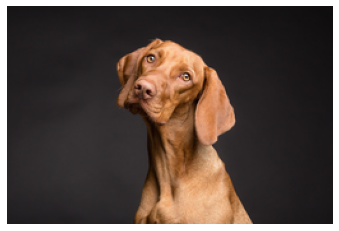

[('vizsla, Hungarian pointer', '75.8%'), ('Rhodesian ridgeback', '5.0%'), ('Weimaraner', '1.8%'), ('English foxhound', '0.3%'), ('redbone', '0.3%')]


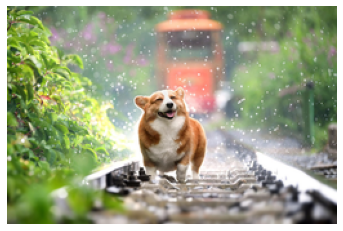

[('Cardigan, Cardigan Welsh corgi', '26.6%'), ('Pembroke, Pembroke Welsh corgi', '24.9%'), ('brambling, Fringilla montifringilla', '1.9%'), ('basenji', '1.2%'), ('goldfish, Carassius auratus', '0.9%')]


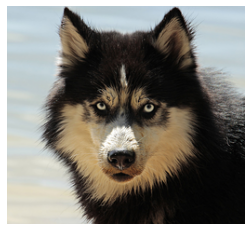

[('Eskimo dog, husky', '74.7%'), ('Siberian husky', '14.6%'), ('timber wolf, grey wolf, gray wolf, Canis lupus', '1.9%'), ('dogsled, dog sled, dog sleigh', '0.7%'), ('white wolf, Arctic wolf, Canis lupus tundrarum', '0.3%')]


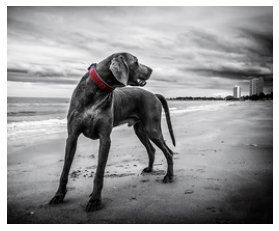

[('Great Dane', '17.8%'), ('Doberman, Doberman pinscher', '8.9%'), ('black-and-tan coonhound', '5.9%'), ('boxer', '4.7%'), ('Weimaraner', '4.7%')]


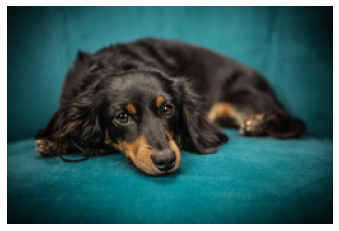

[('Gordon setter', '77.5%'), ('cocker spaniel, English cocker spaniel, cocker', '1.2%'), ('Irish setter, red setter', '1.0%'), ('Sussex spaniel', '0.8%'), ('Rottweiler', '0.4%')]


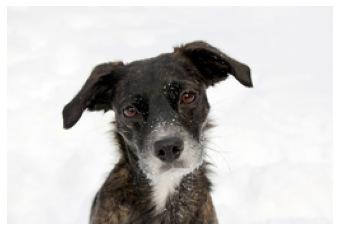

[('Border collie', '28.0%'), ('boxer', '5.3%'), ('Staffordshire bullterrier, Staffordshire bull terrier', '4.7%'), ('Border terrier', '3.9%'), ('Scottish deerhound, deerhound', '2.0%')]


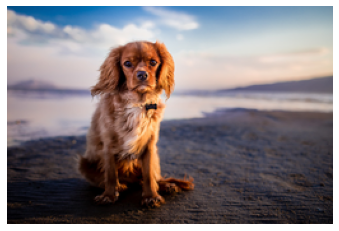

[('cocker spaniel, English cocker spaniel, cocker', '24.2%'), ('Sussex spaniel', '17.1%'), ('Blenheim spaniel', '10.6%'), ('Irish setter, red setter', '3.2%'), ('clumber, clumber spaniel', '2.2%')]


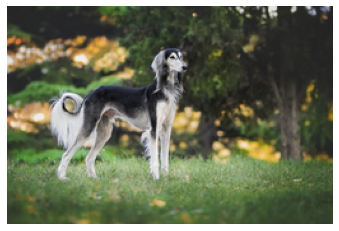

[('Saluki, gazelle hound', '90.9%'), ('borzoi, Russian wolfhound', '1.7%'), ('Eskimo dog, husky', '1.1%'), ('Siberian husky', '0.5%'), ('malamute, malemute, Alaskan malamute', '0.3%')]


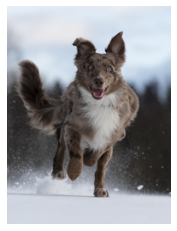

[('Border collie', '38.7%'), ('collie', '17.4%'), ('Australian terrier', '2.4%'), ('Shetland sheepdog, Shetland sheep dog, Shetland', '2.1%'), ('Cardigan, Cardigan Welsh corgi', '1.7%')]


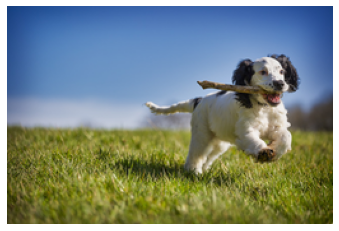

[('English springer, English springer spaniel', '16.9%'), ('Shih-Tzu', '5.4%'), ('Lhasa, Lhasa apso', '5.3%'), ('Japanese spaniel', '4.0%'), ('papillon', '3.6%')]


In [ ]:
model_type = "GPUNet-0" 
precision = "fp64" 

gpunet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_gpunet', pretrained=True, model_type=model_type, model_math=precision)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

gpunet.to(device)

uris = uris

# batch크기 : uris에서 지원
batch = torch.cat(
    [utils.prepare_input_from_uri(uri) for uri in uris]
).to(device)

if precision == "fp16":
    batch = batch.half()
    
print("추론을 진행중입니다....")
with torch.no_grad():
    output = torch.nn.functional.softmax(gpunet(batch), dim=1)
    
results = utils.pick_n_best(predictions=output, n=5)

for uri, result in zip(uris, results):
    img = Image.open(requests.get(uri, stream=True).raw)
    img.thumbnail((256,256), Image.ANTIALIAS)
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    
    print(result)

# 고양이 품종은?

https://cdn.pixabay.com/photo/2017/11/09/21/41/cat-2934720_1280.jpg

https://cdn.pixabay.com/photo/2023/01/30/11/17/maine-coon-7755424_1280.jpg

https://cdn.pixabay.com/photo/2017/02/15/12/12/cat-2068462_1280.jpg

https://cdn.pixabay.com/photo/2020/09/18/13/05/lynx-5581792_1280.jpg

https://cdn.pixabay.com/photo/2016/12/10/13/03/cat-1897232_1280.jpg

In [ ]:
uris = ['https://cdn.pixabay.com/photo/2017/11/09/21/41/cat-2934720_1280.jpg',
        'https://cdn.pixabay.com/photo/2023/01/30/11/17/maine-coon-7755424_1280.jpg',
        'https://cdn.pixabay.com/photo/2017/02/15/12/12/cat-2068462_1280.jpg',
        'https://cdn.pixabay.com/photo/2020/09/18/13/05/lynx-5581792_1280.jpg',
        'https://cdn.pixabay.com/photo/2016/12/10/13/03/cat-1897232_1280.jpg']

model_type= GPUNet-0
mapped model latency= 0.65ms
testing:  batch= 1  latency= 0.65ms  gpu= GV100


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


0B [00:00, ?B/s]

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


추론을 진행중입니다....
sample 0: [('tabby, tabby cat', '32.7%'), ('Egyptian cat', '29.1%'), ('tiger cat', '11.4%'), ('tiger, Panthera tigris', '3.3%'), ('zebra', '0.5%')]
sample 1: [('tabby, tabby cat', '28.4%'), ('tiger cat', '27.9%'), ('lynx, catamount', '6.6%'), ('tiger, Panthera tigris', '2.3%'), ('Egyptian cat', '1.2%')]
sample 2: [('Siamese cat, Siamese', '93.5%'), ('window screen', '0.2%'), ('cougar, puma, catamount, mountain lion, painter, panther, Felis concolor', '0.1%'), ('Egyptian cat', '0.1%'), ('black-footed ferret, ferret, Mustela nigripes', '0.1%')]
sample 3: [('lynx, catamount', '91.9%'), ('Egyptian cat', '0.5%'), ('cougar, puma, catamount, mountain lion, painter, panther, Felis concolor', '0.5%'), ('tiger cat', '0.4%'), ('grey fox, gray fox, Urocyon cinereoargenteus', '0.2%')]
sample 4: [('Persian cat', '71.9%'), ('lynx, catamount', '2.4%'), ('white wolf, Arctic wolf, Canis lupus tundrarum', '1.4%'), ('tabby, tabby cat', '1.3%'), ('snow leopard, ounce, Panthera uncia', '1.1%'

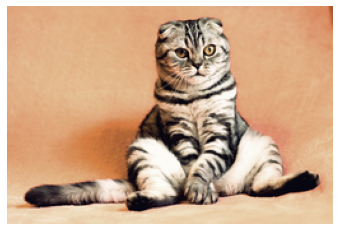

[('tabby, tabby cat', '32.7%'), ('Egyptian cat', '29.1%'), ('tiger cat', '11.4%'), ('tiger, Panthera tigris', '3.3%'), ('zebra', '0.5%')]


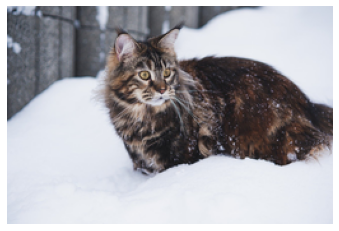

[('tabby, tabby cat', '28.4%'), ('tiger cat', '27.9%'), ('lynx, catamount', '6.6%'), ('tiger, Panthera tigris', '2.3%'), ('Egyptian cat', '1.2%')]


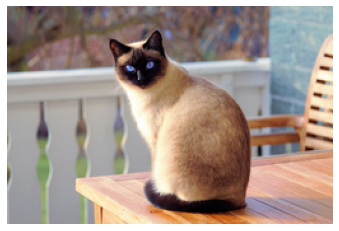

[('Siamese cat, Siamese', '93.5%'), ('window screen', '0.2%'), ('cougar, puma, catamount, mountain lion, painter, panther, Felis concolor', '0.1%'), ('Egyptian cat', '0.1%'), ('black-footed ferret, ferret, Mustela nigripes', '0.1%')]


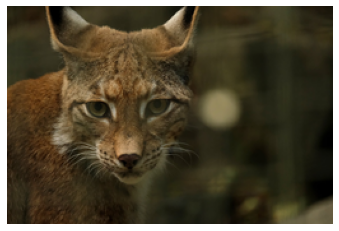

[('lynx, catamount', '91.9%'), ('Egyptian cat', '0.5%'), ('cougar, puma, catamount, mountain lion, painter, panther, Felis concolor', '0.5%'), ('tiger cat', '0.4%'), ('grey fox, gray fox, Urocyon cinereoargenteus', '0.2%')]


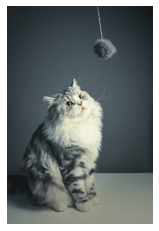

[('Persian cat', '71.9%'), ('lynx, catamount', '2.4%'), ('white wolf, Arctic wolf, Canis lupus tundrarum', '1.4%'), ('tabby, tabby cat', '1.3%'), ('snow leopard, ounce, Panthera uncia', '1.1%')]


In [ ]:
model_type = "GPUNet-0" 
precision = "fp64" 

gpunet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_gpunet', pretrained=True, model_type=model_type, model_math=precision)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

gpunet.to(device)

uris = uris

# batch크기 : uris에서 지원
batch = torch.cat(
    [utils.prepare_input_from_uri(uri) for uri in uris]
).to(device)

if precision == "fp16":
    batch = batch.half()
    
print("추론을 진행중입니다....")
with torch.no_grad():
    output = torch.nn.functional.softmax(gpunet(batch), dim=1)
    
results = utils.pick_n_best(predictions=output, n=5)

for uri, result in zip(uris, results):
    img = Image.open(requests.get(uri, stream=True).raw)
    img.thumbnail((256,256), Image.ANTIALIAS)
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    
    print(result)

# 고양이는 살짝 판단력이 흐려집니다. GPUNET - D2로 진행

model_type= GPUNet-D1
mapped model latency= 1.25ms-D
testing:  batch= 1  latency= 1.25ms-D  gpu= GV100


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


0B [00:00, ?B/s]

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


추론을 진행중입니다....
sample 0: [('knot', '2.4%'), ('quill, quill pen', '1.7%'), ('ballplayer, baseball player', '1.5%'), ('racket, racquet', '1.4%'), ('parallel bars, bars', '1.3%')]
sample 1: [('cockroach, roach', '1.5%'), ('vacuum, vacuum cleaner', '1.0%'), ('puck, hockey puck', '0.9%'), ('harvestman, daddy longlegs, Phalangium opilio', '0.8%'), ('dogsled, dog sled, dog sleigh', '0.8%')]
sample 2: [('Siamese cat, Siamese', '38.8%'), ('gibbon, Hylobates lar', '3.5%'), ('wallaby, brush kangaroo', '3.2%'), ('malinois', '2.0%'), ('langur', '1.5%')]
sample 3: [('lynx, catamount', '8.1%'), ('tiger cat', '2.3%'), ('vizsla, Hungarian pointer', '0.9%'), ('leopard, Panthera pardus', '0.9%'), ('vine snake', '0.9%')]
sample 4: [('envelope', '1.4%'), ('web site, website, internet site, site', '1.1%'), ('rapeseed', '1.0%'), ('groom, bridegroom', '0.9%'), ('cliff, drop, drop-off', '0.8%')]


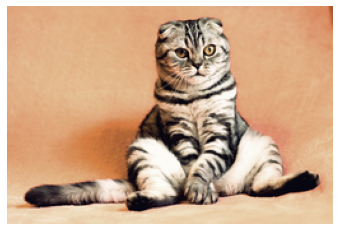

[('knot', '2.4%'), ('quill, quill pen', '1.7%'), ('ballplayer, baseball player', '1.5%'), ('racket, racquet', '1.4%'), ('parallel bars, bars', '1.3%')]


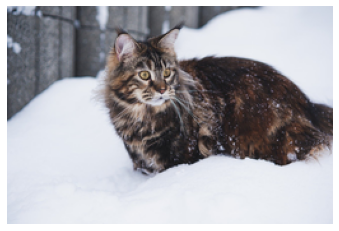

[('cockroach, roach', '1.5%'), ('vacuum, vacuum cleaner', '1.0%'), ('puck, hockey puck', '0.9%'), ('harvestman, daddy longlegs, Phalangium opilio', '0.8%'), ('dogsled, dog sled, dog sleigh', '0.8%')]


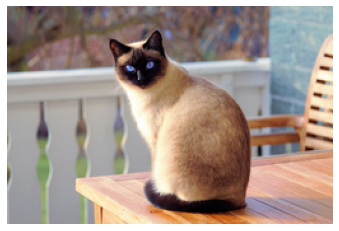

In [ ]:
model_type = "GPUNet-D1" # D2도 고장 
precision = "fp32" 

gpunet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_gpunet', pretrained=True, model_type=model_type, model_math=precision)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

gpunet.to(device)

uris = uris

# batch크기 : uris에서 지원
batch = torch.cat(
    [utils.prepare_input_from_uri(uri) for uri in uris]
).to(device)

if precision == "fp16":
    batch = batch.half()
    
print("추론을 진행중입니다....")
with torch.no_grad():
    output = torch.nn.functional.softmax(gpunet(batch), dim=1)
    
results = utils.pick_n_best(predictions=output, n=5)

for uri, result in zip(uris, results):
    img = Image.open(requests.get(uri, stream=True).raw)
    img.thumbnail((256,256), Image.ANTIALIAS)
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    
    print(result)

# 디테일
모델 입력 및 출력, 학습 레시피, 추론 및 성능에 대한 자세한 내용은 github를 방문하십시오.
[github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Classification/GPUNet)

# 분석
# 4.2.4 Why GPUNet Are Faster and Better?
We also compare the architecture of FBNet and EfficientNet
to GPUNet. Here are a few key differences found by us that
explain the GPUNet performance. Let’s use GPUNet-1 as
an example.

• Mixed types of activation: Fig.6 suggests that GPUNet
switches between RELU and Swish, but EfficientNet
and FBNet use Swish across all the layers. Fig.3.A
suggests Swish greatly increases the latency. Some
layers of GPUNet uses RELU to reduce the latency
for other opportunities to improve the accuracy, e.g.,
larger filters.

• Fewer expansions in IRB: Fig.3.C shows the network
latency almost doubles by increasing the expansions in
all IRB from 1 to 6. The expansion is part of our search
space, so some GPUNet layers tend to have small expansions to save the latency.

• Wider and Deeper: the filters (wide) and the number
of layers (deep) in a stage are part of our search space.
Because of the latency saving from mixed activation
and fewer expansions, GPUNet tends to be wider and
deeper than FBNet and EfficientNet. In the same accuracy group, the filters of FBNetV3-B follow the pattern of 16 → 24 → 40 → 72 → 120 → 183 → 224,
and the filter pattern of EfficientNet-B2 is 32 → 16 →
24 → 48 → 88 → 120 → 208 → 352, but GPUNet1 is a lot wider than FBNetV3-B and EfficientNet-B2
that has a pattern of 24 → 64 → 96 → 160 → 288 → 448. 
- Besides, GPUNet-2 has 33 layers, 2 more than
FBNetV3-F and 5 more than EfficientNet-B3. It is
known that deep and wide networks have better accuracy; therefore, the accuracy of GPUNet is better than
baselines within each group.

• Larger Resolution: GPUNet-(1 and 2) are 32 and 64
larger than EfficientNet-B2 and B3 in resolutions, 72
and 120 larger than FBNetV3-B and FBNetV3-F, respectively. Using large resolution generally improves
the accuracy; therefore, GPUNet shows better accuracy and higher FLOPS than baselines.


### References

 - [GPUNets: Searching Deployable Convolution Neural Networks for GPUs](https://arxiv.org/pdf/2205.00841.pdf)
 - [model on github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Classification/GPUNet)
 - [pretrained model on NGC (GPUNet-0)](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/dle/models/gpunet_0_pyt_ckpt)
 - [pretrained model on NGC (GPUNet-1)](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/dle/models/gpunet_1_pyt_ckpt)
 - [pretrained model on NGC (GPUNet-2)](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/dle/models/gpunet_2_pyt_ckpt)
 - [pretrained distilled model on NGC (GPUNet-P0)](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/dle/models/gpunet_p0_pyt_ckpt)
 - [pretrained, distilled model on NGC (GPUNet-P1)](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/dle/models/gpunet_p1_pyt_ckpt)
 - [pretrained, distilled model on NGC (GPUNet-D1)](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/dle/models/gpunet_d1_pyt_ckpt)
 - [pretrained, distilled model on NGC (GPUNet-D2)](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/dle/models/gpunet_d2_pyt_ckpt)